In [7]:
#Importing Dependencies

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import glob as glob
import csv
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Lambda, Convolution2D, Activation, Cropping2D, Dropout
from skimage import transform as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import random


    
    

In [8]:

def extract_camera_pos(lines, camera_pos):
#The images path and associated steering angle are appended to lists. If the camera position is left or right, 
# an additional correction factor 0.2 is added/subracted to the steering angle. 
#Lines: lines list extracted from driving_csv file.
#camera_pos: 'center', 'left' or 'right'
    
    X,y=[],[]
    
    if camera_pos=='center':
        pos=0
        correction=0
    if camera_pos=='left':
        pos=1
        correction=0.2
    if camera_pos=='right':
        pos=2
        correction=-0.2
        
    for i in range(0, len(lines)):
        X.append(lines[i][pos])
        y.append(float(lines[i][3])+correction)
        
    return X,y    

In [9]:
def data_loading():
    
    #reads the csv into a list
    
    with open('./examples/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        lines = []
        next(reader)
        for row in reader:
            lines.append(row)
    #appened each camera position image path and associated steering angle into separate list
    
    X_center, y_center = extract_camera_pos(lines, camera_pos='center')    
    X_left, y_left = extract_camera_pos(lines, camera_pos='left')
    X_right, y_right = extract_camera_pos(lines, camera_pos='left')
    
    #merging all position single list
    X_all, y=[], []
    X_all.extend(X_center)
    X_all.extend(X_left)
    X_all.extend(X_right)
    y.extend(y_center)
    y.extend(y_left)
    y.extend(y_right)
    

    #modifying the absolute path to relatvie path
    test_img =[]
    X=[]
    for i in range(len(X_all)):
        filename = X_all[i].split('/')[-1]
        path = './examples/IMG/'+ filename
        X.append(path)
        if i <10:
            test_img.append(mpimg.imread(path))
    return X, y, test_img

In [10]:
def image_augmentation(img_list, steering_angle):
    
    #Cropping image
    crop_img=[]
    for i in range(len(img_list)):
        crop_img.append(img_list[i][60:140])
    
     
    crop_img=np.array(crop_img)   
    #Resizing image
    resized_img=[]
    for i in range(len(crop_img)):
        resized_img.append(cv2.resize(crop_img[i],None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC))
    
    #Image Sheering
    sheared_img=[]
    for i in range(0, len(resized_img),3): 
        rand_value = round(random.uniform(-1,1),1)
        #Create Afine transform
        afine_tf = tf.AffineTransform(shear=0.8)
        # Apply transform to image data
        resized_img.append(tf.warp(resized_img[i], inverse_map=afine_tf))
        steering_angle.append(steering_angle[i])

    
    y_steer = []
    for item in steering_angle:
        y_steer.append(float(item))


    #Image flipping
    X_img = np.array(resized_img)
    y_steer =np.array(y_steer)    
    for i in range(0, len(X_img), 3):
        X_img[i]= np.fliplr(X_img[i])
        y_steer[i]= -y_steer[i]
                           
    return X_img, y_steer, crop_img, resized_img, img_list

In [11]:
X,y,test_img = data_loading()  

In [12]:
len(test_img)

10

In [13]:
x,y, crop_img, resized_img, img_list=image_augmentation(test_img,y)

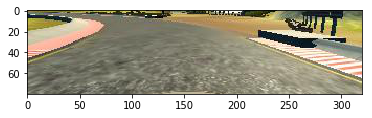

In [174]:
plt.imshow(crop_img[])

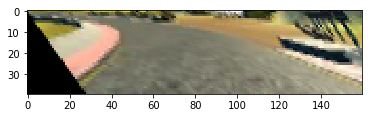

In [175]:
plt.imshow(resized_img[11])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [8]:
def image_generator(img_path_list, steering_angle, batch_size):
    
    num_of_samples=len(img_path_list)
    
    while True:
        for offset in range(0, num_of_samples, batch_size):

            x_img_batch, y_steer_batch = img_path_list[offset:offset+batch_size],\
                                         steering_angle[offset:offset+batch_size]
        
            img=[]
            
            for i in range(len(x_img_batch)):
                path = x_img_batch[i]
                img.append(mpimg.imread(path))
            
            X_img, y_steer = image_augmentation(img_list=img, steering_angle = y_steer_batch)
                
            yield shuffle(X_img, y_steer)
        
        
    

In [9]:
def train_data_generator(batch_size=128):
        return image_generator(img_path_list=X_train, steering_angle=y_train, batch_size=batch_size)

def valid_data_generator(batch_size=128):
        return image_generator(img_path_list=X_valid, steering_angle=y_valid, batch_size=batch_size,)

In [11]:
model = Sequential()
model.add(Lambda(lambda x:x/127.5-1.0, input_shape=(40,160,3)))
#model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,(5,5), strides=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(36,(5,5),strides=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(48,(5,5)))
model.add(Activation('elu'))
model.add(Convolution2D(64,(3,3)))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit_generator(generator=train_data_generator(2000),\
                    epochs=1, steps_per_epoch =5, \
                    validation_data=valid_data_generator(2000), validation_steps=3)
model.save('model.h5')
model.summary()

Epoch 1/10
5/5 [==============================] - 37s - loss: 0.2215 - val_loss: 0.1046
Epoch 2/10
5/5 [==============================] - 21s - loss: 0.0683 - val_loss: 0.0507
Epoch 3/10
5/5 [==============================] - 18s - loss: 0.0482 - val_loss: 0.0460
Epoch 4/10
5/5 [==============================] - 23s - loss: 0.0451 - val_loss: 0.0358
Epoch 5/10
5/5 [==============================] - 22s - loss: 0.0392 - val_loss: 0.0369
Epoch 6/10
5/5 [==============================] - 18s - loss: 0.0379 - val_loss: 0.0365
Epoch 7/10
5/5 [==============================] - 23s - loss: 0.0378 - val_loss: 0.0352
Epoch 8/10
5/5 [==============================] - 21s - loss: 0.0358 - val_loss: 0.0341
Epoch 9/10
5/5 [==============================] - 18s - loss: 0.0347 - val_loss: 0.0324
Epoch 10/10
5/5 [==============================] - 22s - loss: 0.0333 - val_loss: 0.0314


In [13]:
from keras.models import load_model

model= load_model('model.h5')

model.fit_generator(generator=train_data_generator(2000),\
                    epochs=10, steps_per_epoch =11, \
                    validation_data=valid_data_generator(2000), validation_steps=3)
model.save('model.h5')


Epoch 1/10
11/11 [==============================] - 59s - loss: 0.0245 - val_loss: 0.0233
Epoch 2/10
11/11 [==============================] - 43s - loss: 0.0243 - val_loss: 0.0230
Epoch 3/10
11/11 [==============================] - 42s - loss: 0.0240 - val_loss: 0.0228
Epoch 4/10
11/11 [==============================] - 46s - loss: 0.0236 - val_loss: 0.0227
Epoch 5/10
11/11 [==============================] - 45s - loss: 0.0235 - val_loss: 0.0224
Epoch 6/10
11/11 [==============================] - 41s - loss: 0.0231 - val_loss: 0.0223
Epoch 7/10
11/11 [==============================] - 47s - loss: 0.0231 - val_loss: 0.0219
Epoch 8/10
11/11 [==============================] - 44s - loss: 0.0229 - val_loss: 0.0223
Epoch 9/10
11/11 [==============================] - 41s - loss: 0.0227 - val_loss: 0.0219
Epoch 10/10
11/11 [==============================] - 44s - loss: 0.0224 - val_loss: 0.0216
